In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as p
from sklearn.cross_validation import KFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif


redundant_features = []
useful_features = []

def import_data():
    # For .read_csv, always use header=0 when you know row 0 is the header row
    df = pd.read_csv("./data/ElectionsData-full.csv", header=0)

    df['split'] = 0
#     indices = KFold(n=len(df), n_folds=5, shuffle=True)._iter_test_indices()
#     df['split'][indices.next()] = 1
#     df['split'][indices.next()] = 2
#     raw_data = df.copy()

#     raw_data[raw_data['split'] == 0].drop('split', axis=1).to_csv('./data/output/raw_train.csv', index=False, sep=',')
#     raw_data[raw_data['split'] == 1].drop('split', axis=1).to_csv('./data/output/raw_test.csv', index=False, sep=',')
#     raw_data[raw_data['split'] == 2].drop('split', axis=1).to_csv('./data/output/raw_validation.csv', index=False)

    return df


def export_transformed_data(_df):
    _df[_df['split'] == 0].drop('split', axis=1).to_csv('./data/output/processed_train.csv', index=False)
    _df[_df['split'] == 1].drop('split', axis=1).to_csv('./data/output/processed_test.csv', index=False)
    _df[_df['split'] == 2].drop('split', axis=1).to_csv('./data/output/processed_validation.csv', index=False)


def group_features(_df):
    _df = _df.dropna()
    all_features = _df.drop(['Vote', 'split'], axis=1).columns
    categorical_features = _df.drop(['Vote', 'split'], axis=1).select_dtypes(include=["object"])
    numeric_features = _df.drop(['Vote', 'split'], axis=1).select_dtypes(exclude=["object"])

    return [all_features, categorical_features, numeric_features]


def fill_numeric_features(_df, features):
    for f in features:
        _df[f].fillna(_df[f].median(), inplace=True)


def fill_categorical_features(_df, features):
    for f in features:
        _df[f].fillna(_df[f].value_counts().idxmax(), inplace=True)


def transform_categorical_features(_df, features):
    for f in features:
        _df[f] = _df[f].astype("category")
        _df[f + "_Int"] = _df[f].cat.rename_categories(range(_df[f].nunique())).astype(int)
        _df.loc[_df[f].isnull(), f + "_Int"] = np.nan  # fix NaN conversion3


def transform_label(_df, label):
    _df[label] = _df[label].astype("category").cat.rename_categories(range(_df[label].nunique())).astype(int)

def outliar_detection(_df, features):
    # Outliar detection
    threshold = 3
    for f in numeric_features:
        std = _df[f].std()
        mean = _df[f].mean()
        _df = _df[_df[f].between(mean - threshold * std, mean + threshold * std)]
    return _df

def scale_numeric(_df, features):
    for f in features:
        _df[f] = (_df[f] - _df[f].min()) / (_df[f].max() - _df[f].min())


def transform_bool(_df, name):
    _df[name] = _df[name].map({'No': -1, "Maybe": 0, 'Yes': 1}).astype(int)

def transform_category(_df, name):
    redundant_features.append(name)
    for cat in df[name].unique():
        _df["Is_" + name + "_" + cat] = (_df[name] == cat).astype(int)
    del _df[name]

        
def transform_manual(_df):
    _df["Age_group"] = _df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(int)
    _df["Voting_Time"] = _df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(int)
    _df["Gender"] = _df["Gender"].map({'Male': -1, 'Female': 1}).astype(int)
    
    
    transform_bool(_df, "Looking_at_poles_results")
    transform_bool(_df, "Married")
    transform_bool(_df, "Financial_agenda_matters")
    transform_bool(_df, "Will_vote_only_large_party")
    transform_category(_df, "Most_Important_Issue")
    transform_category(_df, "Occupation")
    transform_category(_df, "Main_transportation")

def to_np_array(_df):
    df_data_X = _df.drop(['split','Vote'], axis=1).values
    df_data_Y = _df.Vote.values
    features_list = _df.drop(['split','Vote'], axis=1).columns
    return [df_data_X, df_data_Y, features_list]
        
def variance_filter(data_X, features_list):
    varsel = VarianceThreshold(threshold=0.01)
    varsel.fit_transform(data_X)
    featsel_idx = varsel.get_support()
    print 'Removing features with low variance - ', '\t', list(features_list[~featsel_idx])
    return list(features_list[~featsel_idx])
        
def select_features_with_rfe(data_X, data_Y, feature_names):
    result = []
    
    svc = SVC(kernel="linear", C=1)
    rfecv = RFECV(estimator=svc, step=1, cv=3, scoring='accuracy')
    rfecv.fit(data_X, data_Y)

    print("RFE - Optimal number of features : %d" % rfecv.n_features_)
    
    for idx, val in enumerate(rfecv.get_support()):
        if val:
            print "RFE - Choosing feature: " + feature_names[idx]
            result.append(feature_names[idx]) 
    return result

def univariate_features_with_mi(data_X, data_Y, feature_names):
    result = []
    
    selector = SelectPercentile(mutual_info_classif, percentile=25)
    selector.fit(data_X, data_Y)

    for idx, val in enumerate(selector.get_support()):
        if val:
            result.append(feature_names[idx]) 
            print "MI - Choosing feature: " + feature_names[idx]
    
    return result



def univariate_features_with_f_classif(data_X, data_Y, feature_names):
    result = []
    
    selector = SelectPercentile(f_classif, percentile=25)
    selector.fit(data_X, data_Y)

    for idx, val in enumerate(selector.get_support()):
        if val:
            result.append(feature_names[idx]) 
            print "f-classif - Choosing feature: " + feature_names[idx]
    
    return result

    
def univariate_features_with_f_classif(data_X, data_Y, feature_names):
    result = []
    
    selector = SelectPercentile(f_classif, percentile=25)
    selector.fit(data_X, data_Y)

    for idx, val in enumerate(selector.get_support()):
        if val:
            result.append(feature_names[idx]) 
            print "f-classif - Choosing feature: " + feature_names[idx]
    
    return result
     
def embedded_features_by_descision_tree(data_X, data_Y, feature_names):    
    result = []

    clf = ExtraTreesClassifier()
    clf = clf.fit(data_X, data_Y)
    tree_weights = clf.feature_importances_  
    tree_weights /= tree_weights.max()
    tree_booleans = tree_weights > np.percentile(tree_weights, 75)
    for idx, val in enumerate(tree_booleans):
        if val:
            result.append(feature_names[idx]) 
            print "Tree Clasifier - Choosing feature: " + feature_names[idx]
    
    return result
    
# redundant_features = []
# useful_features = []

df = import_data()

all_features, categorical_features, numeric_features = group_features(df)

fill_numeric_features(df, numeric_features)
fill_categorical_features(df, categorical_features)
# transform_categorical_features(df, categorical_features)  # We Don't need that!!
transform_label(df, "Vote")
transform_manual(df)


print "Before outliar detacction: " + str(df.shape[0])
df = outliar_detection(df, numeric_features)
print "After outliar detacction: " + str(df.shape[0])

df_data_X, df_data_Y, features_list = to_np_array(df)
df_data_X = preprocessing.scale(df_data_X)

features_to_exclude = variance_filter(df_data_X, features_list)
redundant_features.extend(features_to_exclude)


good_features = select_features_with_rfe(df_data_X, df_data_Y, features_list)
useful_features.extend(good_features)

good_features = univariate_features_with_mi(df_data_X, df_data_Y, features_list)
useful_features.extend(good_features)

good_features = univariate_features_with_f_classif(df_data_X, df_data_Y, features_list)
useful_features.extend(good_features)

good_features = embedded_features_by_descision_tree(df_data_X, df_data_Y, features_list)
useful_features.extend(good_features)

useful_features = list(set(useful_features))

print useful_features, useful_features.count()

# export_transformed_data(df)




Before outliar detacction: 10000
After outliar detacction: 8543
Removing features with low variance -  	[]
RFE - Optimal number of features : 18
RFE - Choosing feature: Avg_monthly_expense_when_under_age_21
RFE - Choosing feature: Looking_at_poles_results
RFE - Choosing feature: Garden_sqr_meter_per_person_in_residancy_area
RFE - Choosing feature: Married
RFE - Choosing feature: Yearly_IncomeK
RFE - Choosing feature: Avg_monthly_expense_on_pets_or_plants
RFE - Choosing feature: Avg_monthly_household_cost
RFE - Choosing feature: Will_vote_only_large_party
RFE - Choosing feature: Phone_minutes_10_years
RFE - Choosing feature: Avg_size_per_room
RFE - Choosing feature: Weighted_education_rank
RFE - Choosing feature: Last_school_grades
RFE - Choosing feature: Political_interest_Total_Score
RFE - Choosing feature: Number_of_valued_Kneset_members
RFE - Choosing feature: Overall_happiness_score
RFE - Choosing feature: Is_Most_Important_Issue_Military
RFE - Choosing feature: Is_Most_Important_I

TypeError: count() takes exactly one argument (0 given)

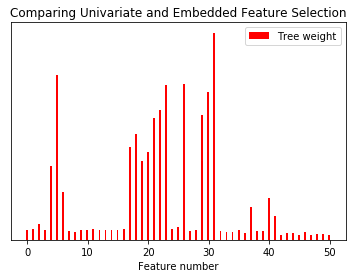

In [75]:
clf = ExtraTreesClassifier()
clf = clf.fit(df_data_X, df_data_Y)
tree_weights = clf.feature_importances_  
tree_weights /= tree_weights.max()


X_indices = np.arange(df_data_X.shape[-1])

plt.bar(X_indices - .05, tree_weights, width=.3, 
        label='Tree weight', color='r')
# plt.bar(X_indices - .35, MI_scores, width=.3,
#         label='MI', color='b')
# plt.bar(X_indices - .65, f_scores, width=.3,
#         label='f_classif', color='g')


plt.title("Comparing Univariate and Embedded Feature Selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()